In [1]:
import numpy as np
import cv2

In [55]:
import matplotlib.pylab as plt
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_gray(img):  
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    
img = cv2.imread('archive/lena.jpg')

In [65]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (21, 21),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [66]:
# Take first frame and find corners in it
old_frame = cv2.imread('archive/IMG_0087.JPG')

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

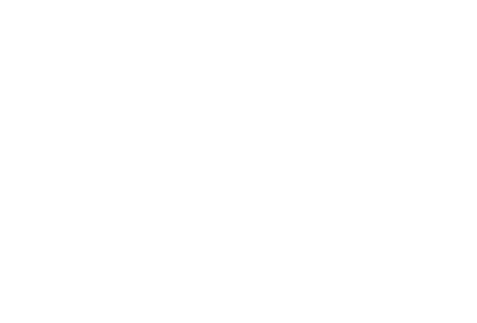

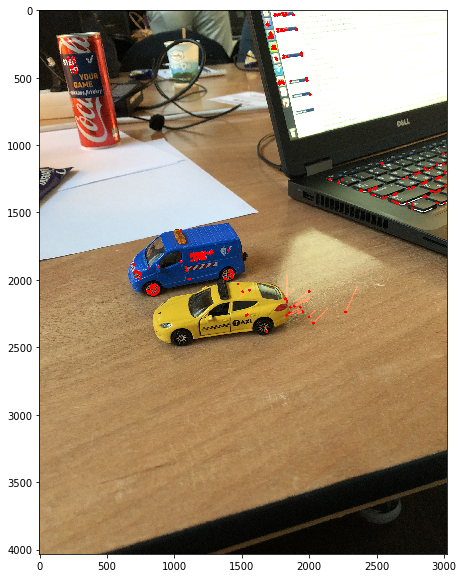

In [67]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame = cv2.imread('archive/IMG_0088.JPG')
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
# Select good points
good_new = p1[st==1]
good_old = p0[st==1]
# draw the tracks
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 10)
    frame = cv2.circle(frame,(a,b),5, (0,0,255), 10)
    
img = cv2.add(frame, mask)
show(img)